In [1]:
import sys
# SITE_PACKAGES_PATH = '/home/rpartsey/miniconda3/envs/benchbot/lib/python3.8/site-packages'
# if SITE_PACKAGES_PATH not in sys.path:
#     sys.path.insert(0, SITE_PACKAGES_PATH)
PROJECT_ROOT = '../..'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)  # add project roo dir to the path

import os
import copy
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint, pformat
from scipy.spatial.transform import Rotation as Rot
from sklearn.cluster import DBSCAN

from utils.common.utils import (
    compute_fov,
    polar_to_cart,
    compute_normals,
)

from utils.vis.utils import (
    ObservationVisualiser, 
    _vis_depth, 
    _vis_laser, 
    _vis_rgb,  
    _vis_poses, 
    _set_axes_equal,
    # plot_fov_bounds,
    plot_scan,
    plot_normals
)

%matplotlib inline

In [2]:
scenes = [
    'miniroom_1_observations.p',
    'miniroom_1_nav_policy_observations.p',
    'house_1_observations.p',
    'house_1_nav_policy_observations.p'
]
scene_id = 1
observations_path = f'../../data/{scenes[scene_id]}'

In [3]:
with open(observations_path, 'rb') as f:
    observations_data = pickle.load(f)
    
observations = observations_data['observations']

## Navigation Policy

observation['laser']['scans'] == N x [distance, angle]

### Compute Camera FOV

In [4]:
obs = observations[0]

camera_info = obs['image_rgb_info']
# camera_info = obs['image_depth_info']
print('Camera info:\n', pformat(camera_info),'\n')
matrix_intrinsics = camera_info['matrix_intrinsics']

w = camera_info['width']
h = camera_info['height']
fx = matrix_intrinsics[0, 0]
fy = matrix_intrinsics[1, 1]

fov_x_rad = compute_fov(w, fx)
fov_y_rad = compute_fov(h, fy)

fov_x = np.rad2deg(fov_x_rad)
fov_y = np.rad2deg(fov_y_rad)

print("Field of View (degrees):")
print(f"  {fov_x = :.1f}\N{DEGREE SIGN}")
print(f"  {fov_y = :.1f}\N{DEGREE SIGN}")

Camera info:
 {'frame_id': 'carter_camera_stereo_left',
 'height': 720,
 'matrix_intrinsics': array([[671.91601562,   0.        , 640.        ],
       [  0.        , 672.94030762, 360.        ],
       [  0.        ,   0.        ,   1.        ]]),
 'matrix_projection': array([[671.91601562,   0.        , 640.        ,   0.        ],
       [  0.        , 672.94030762, 360.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]]),
 'width': 1280} 

Field of View (degrees):
  fov_x = 87.2°
  fov_y = 56.3°


In [5]:
def cluster_data(scan_points, eps=0.1, min_samples=5, **kwargs):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, **kwargs).fit(
        scan_points
    )
    
    return clustering
        
        
def show_clusters(scan_points, clustering, figsize=(12, 6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121)

    for label in np.unique(clustering.labels_):
        plot_scan(ax, scan_points[clustering.labels_ == label], s=4, marker='s')
        
        if label == -1:
            ax = fig.add_subplot(122)

    plt.show()
        
def cluster_and_show(scan_points, eps=0.1, min_samples=5, figsize=(12, 6)):
    clustering = cluster_data(
        scan_points, 
        eps=eps, 
        min_samples=min_samples
    )
    show_clusters(scan_points, clustering, figsize)

    return clustering

### Clustering Based Navogation 

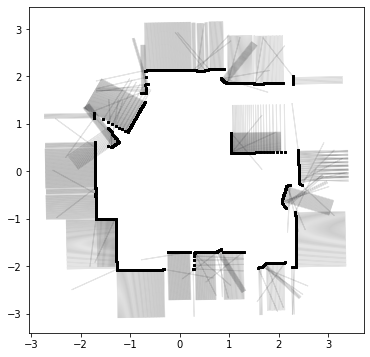

In [6]:
obs = observations[0]

scan_points_polar = obs['laser']['scans']
scan_points = polar_to_cart(scan_points_polar)
scan_points = np.concatenate(
    (
        scan_points,
        np.zeros((scan_points.shape[0], 1))
    ),
    axis=1
)

z_norm = compute_normals(scan_points)

# scan_points_flip = np.flip(np.copy(scan_points), axis=0)
# z_norm_flip = compute_normals(scan_points_flip)
# z_norm_2 = np.flip(z_norm_flip, axis=0)

# z_norm -= z_norm_2
# z_norm /= 2

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

plot_scan(ax, scan_points, c='k', s=4, marker='s')
plot_normals(ax, scan_points, z_norm)

plt.show()

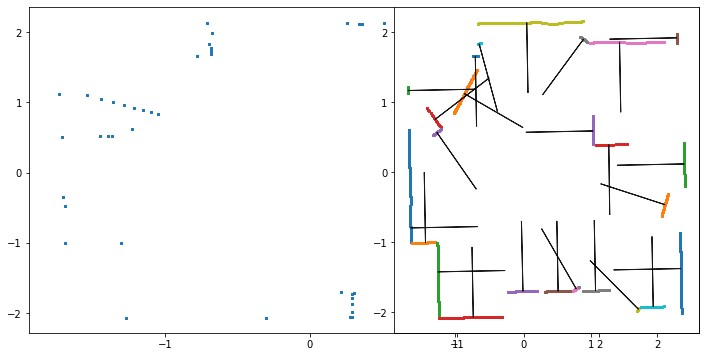

In [7]:
eps = 0.09
min_samples = 4

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(
    np.concatenate(
    (
        scan_points[:,:2], 
        z_norm[:,:2]
    ), 
    axis=1
)
)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

for label in np.unique(clustering.labels_):
    plot_scan(ax, scan_points[clustering.labels_ == label], s=4, marker='s')

    if label == -1:
        ax = fig.add_subplot(122)

z_norm_avg = -np.copy(z_norm)
for label in np.unique(clustering.labels_)[1:]:
    mask = clustering.labels_ == label
    indices, = np.where(mask)
    
    avg_norm = np.average(z_norm_avg[mask], axis=0)
    z_norm_avg[mask] = avg_norm
    
    origin = scan_points[indices[indices.shape[0] // 2]]
    ax.arrow(origin[0], origin[1], avg_norm[0], avg_norm[1], alpha=0.9)
    
plt.show()

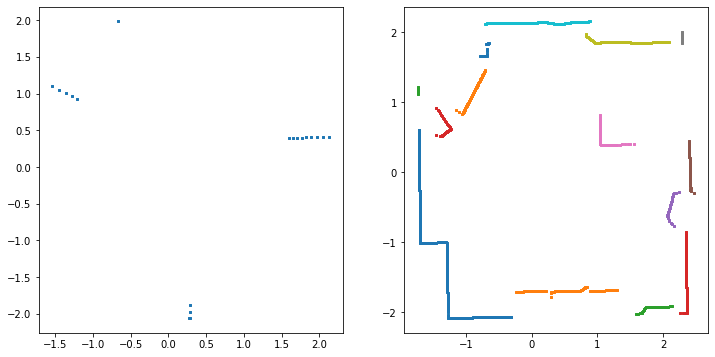

DBSCAN(eps=0.09, min_samples=4)

In [8]:
cluster_and_show(
    scan_points[:, :2], 
    eps=0.09, 
    min_samples=4
)

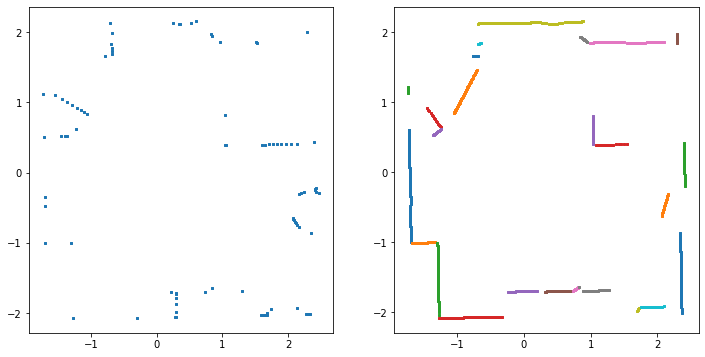

DBSCAN(eps=0.09, min_samples=4)

In [9]:
cluster_and_show(
    np.concatenate(
        (
            scan_points[:,:2], 
            z_norm[:,:2]
        ), 
        axis=1
    ),
    eps=0.09, 
    min_samples=4
)

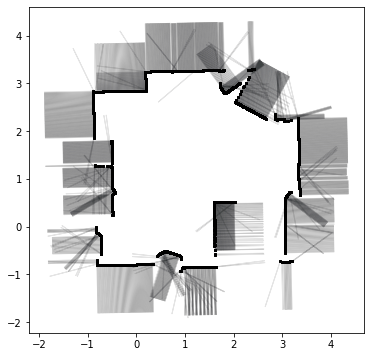

In [10]:
obs_list = []
for obs in observations[:2]:
    poses = copy.deepcopy(obs['poses'])

    lidar = poses['lidar']
    origin = lidar['translation_xyz']
    
    orientation = lidar['rotation_rpy']
    rot_obj = Rot.from_euler('xyz', orientation)
            
    scan_points_polar = obs['laser']['scans']
    scan_points_polar = np.array([x for x in scan_points_polar if x[0] < 10]) # remove outliers
    scan_points = polar_to_cart(scan_points_polar)
    scan_points = np.concatenate(
        (
            scan_points,
            np.zeros((scan_points.shape[0], 1))
        ),
        axis=1
    )
    
    scan_points_rot = np.array([rot_obj.apply(p) for p in scan_points])
    scan_points_rot_trans = np.array([(np.array(p)+origin).tolist() for p in scan_points_rot])

    obs_list.append(scan_points_rot_trans)

    
scan_points = np.concatenate(
    obs_list,
    axis=0
)

z_norm = compute_normals(scan_points)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

plot_scan(ax, scan_points, c='k', s=4, marker='s')
plot_normals(ax, scan_points, z_norm)

plt.show()

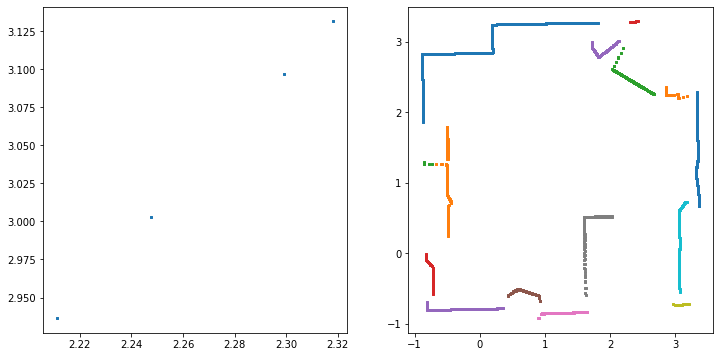

DBSCAN(eps=0.09, min_samples=4)

In [11]:
cluster_and_show(
    scan_points[:, :2], 
    eps=0.09, 
    min_samples=4
)

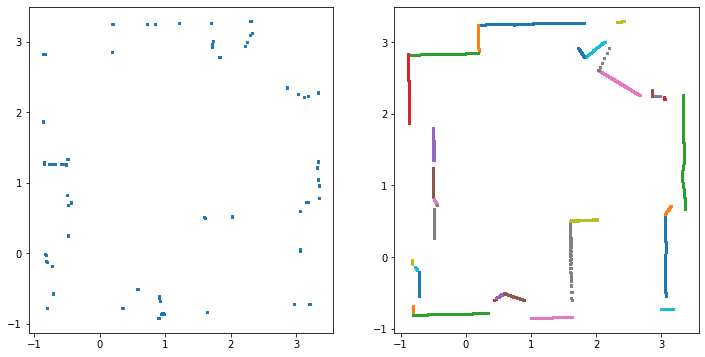

DBSCAN(eps=0.09, min_samples=4)

In [12]:
cluster_and_show(
    np.concatenate(
        (
            scan_points[:,:2], 
            z_norm[:,:2]
        ), 
        axis=1
    ), 
    eps=0.09, 
    min_samples=4 
)